In [ ]:


import os
import polars as pl
import dotenv
from tqdm import tqdm
import plotly.graph_objects as go
FOLDER_PATH = os.getenv("FOLDER_PATH")
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm
from scipy.optimize import curve_fit


dotenv.load_dotenv()
# +
# Get list of all stocks from .env
stocks_list = ["GOOGL", "AAPL", "AMZN", "AAL", "MSFT", "GT", "INTC", "IOVA", "PTEN", 
               "MLCO", "PTON", "VLY", "VOD", "CSX", "WB", "BGC", "GRAB", "KHC", "HLMN",
               "IEP", "GBDC", "WBD", "PSNY", "NTAP", "GEO", "LCID", "GCMG", "CXW", 
               "RIOT", "HL", "CX", "ERIC", "UA"]

# Get parquet files for each stock and count occurrences of each date
stock_files = {}
date_counts = {}
date_stocks = {}  # Dictionary to store stocks for each date
for stock in stocks_list:
    files = [f for f in os.listdir(f"{FOLDER_PATH}{stock}") if f.endswith('.parquet')]
    files.sort()
    stock_files[stock] = set(files)
    
    # Count occurrences of each date and store stocks
    for file in files:
        # Extract date from filename (remove stock prefix and .parquet suffix)
        date = file.replace(f"{stock}_", "").replace(".parquet", "")
        if date in date_counts:
            date_counts[date] += 1
            date_stocks[date].append(stock)
        else:
            date_counts[date] = 1
            date_stocks[date] = [stock]

# Find the most common date
print(date_counts)
print("Stocks for each date:", date_stocks)
most_common_date = max(date_counts.items(), key=lambda x: x[1])[0]
print(f"Most common date across stocks: {most_common_date}")

# -

#

# +
# Get all dates with maximum count
max_count = max(date_counts.values())
most_common_dates = [date for date, count in date_counts.items() if count == max_count]
print(f"Dates with maximum count ({max_count} stocks): {most_common_dates}")
print("stocks for most common date:", date_stocks[most_common_dates[0]])
# Create empty list to store all dataframes
all_dfs = {stock: pl.DataFrame() for stock in date_stocks[most_common_dates[0]]}

# Load and combine data for each date
for date in most_common_dates[:1]:
    print(f"\nProcessing date: {date}")
    stocks_for_date = date_stocks[date]
    
    # Load data for each stock on this date
    for stock in tqdm(stocks_for_date):
        file_path = f"{FOLDER_PATH}{stock}/{stock}_{date}.parquet"
        if os.path.exists(file_path):
            df = pl.read_parquet(file_path)
            all_dfs[stock] = pl.concat([all_dfs[stock], df])





def curate_mid_price(df,stock):
    if "publisher_id" in df.columns:
        num_entries_by_publisher = df.group_by("publisher_id").len().sort("len", descending=True)
        if len(num_entries_by_publisher) > 1:
                df = df.filter(pl.col("publisher_id") == 41)
        
        
    if stock == "GOOGL":
        df = df.filter(pl.col("ts_event").dt.hour() >= 13)
        df = df.filter(pl.col("ts_event").dt.hour() <= 20)
        
        
    else:
        df = df.filter(
            (
                (pl.col("ts_event").dt.hour() == 9) & (pl.col("ts_event").dt.minute() >= 35) |
                (pl.col("ts_event").dt.hour() > 9) & (pl.col("ts_event").dt.hour() < 16)
            )
        )
    
    # Remove the first row at 9:30
    df = df.with_row_index("index").filter(
        ~((pl.col("ts_event").dt.hour() == 9) & 
          (pl.col("ts_event").dt.minute() == 30) & 
          (pl.col("index") == df.filter(
              (pl.col("ts_event").dt.hour() == 9) & 
              (pl.col("ts_event").dt.minute() == 30)
          ).with_row_index("index").select("index").min())
        )
    ).drop("index")
    mid_price = (df["ask_px_00"] + df["bid_px_00"]) / 2
    
    # managing nans or infs, preceding value filling
    mid_price = mid_price.fill_nan(mid_price.shift(1))
    df = df.with_columns(mid_price=mid_price)
    # sort by ts_event
    # added microprice
    microprice = (df["ask_px_00"]*df["bid_sz_00"] + df["bid_px_00"]*df["ask_sz_00"]) / (df["ask_sz_00"] + df["bid_sz_00"])
    # remove nans or infs
    microprice = microprice.fill_nan(microprice.shift(1))
    df = df.with_columns(microprice=microprice)
    df = df.sort("ts_event")
    return df


for stock in tqdm(date_stocks[most_common_dates[0]], "Huge amount of data to process"):
        df = all_dfs[stock]
        df  = curate_mid_price(df,stock)
        all_dfs[stock] = df


Python-dotenv could not parse statement starting at line 4
Python-dotenv could not parse statement starting at line 5
Python-dotenv could not parse statement starting at line 6
Python-dotenv could not parse statement starting at line 7
Python-dotenv could not parse statement starting at line 8
Python-dotenv could not parse statement starting at line 9
Python-dotenv could not parse statement starting at line 10


{'2024-07-22': 15, '2024-07-23': 15, '2024-07-24': 15, '2024-07-25': 15, '2024-07-26': 15, '2024-07-29': 15, '2024-07-30': 15, '2024-07-31': 15, '2024-08-01': 15, '2024-08-02': 15, '2024-08-05': 15, '2024-08-06': 15, '2024-08-07': 15, '2024-08-08': 15, '2024-08-09': 15, '2024-08-12': 15, '2024-08-13': 15, '2024-08-14': 15, '2024-08-15': 15, '2024-08-16': 15, '2024-08-19': 15, '2024-08-20': 15, '2024-08-21': 15, '2024-08-22': 15, '2024-08-23': 15, '2024-08-26': 15, '2024-08-27': 15, '2024-08-28': 15, '2024-08-29': 15, '2024-08-30': 15, '2024-09-03': 15, '2024-09-04': 15, '2024-09-05': 15, '2024-09-06': 15, '2024-09-09': 15, '2024-09-10': 15, '2024-09-11': 15, '2024-09-12': 15, '2024-09-13': 15, '2024-09-16': 15, '2024-09-17': 15, '2024-09-18': 15, '2024-09-19': 15, '2024-09-20': 15, '2024-09-23': 15, '2024-09-24': 15, '2024-09-25': 15, '2024-09-26': 15, '2024-09-27': 15, '2024-09-30': 15, '2024-10-01': 15, '2024-10-02': 15, '2024-10-03': 15, '2024-10-04': 15, '2024-10-07': 15, '2024-10-

Huge amount of data to process: 100%|██████████| 15/15 [00:01<00:00, 14.78it/s]



Calculating correlation matrices for microprice variations...

Processing time scale: 10ms
Processing stock: GOOGL
First 5 variations for GOOGL:
[ 0.00097218  0.         -0.00035794  0.         -0.00201032]
Number of data points for GOOGL: 220871
Processing stock: AAL
First 5 variations for AAL:
[-1.76553346e-03 -8.72163289e-06 -9.60357960e-05 -3.67584108e-03
  6.22252243e-03]
Number of data points for AAL: 54239
Processing stock: GT
First 5 variations for GT:
[ 0.          0.          0.          0.00192178 -0.00091288]
Number of data points for GT: 30676
Processing stock: INTC
First 5 variations for INTC:
[-0.01971906  0.00651465  0.00017503  0.00267091 -0.00204462]
Number of data points for INTC: 159921
Processing stock: MLCO
First 5 variations for MLCO:
[ 0.          0.          0.         -0.00028116  0.00093516]
Number of data points for MLCO: 16014
Processing stock: VLY
First 5 variations for VLY:
[0. 0. 0. 0. 0.]
Number of data points for VLY: 31759
Processing stock: CSX
First

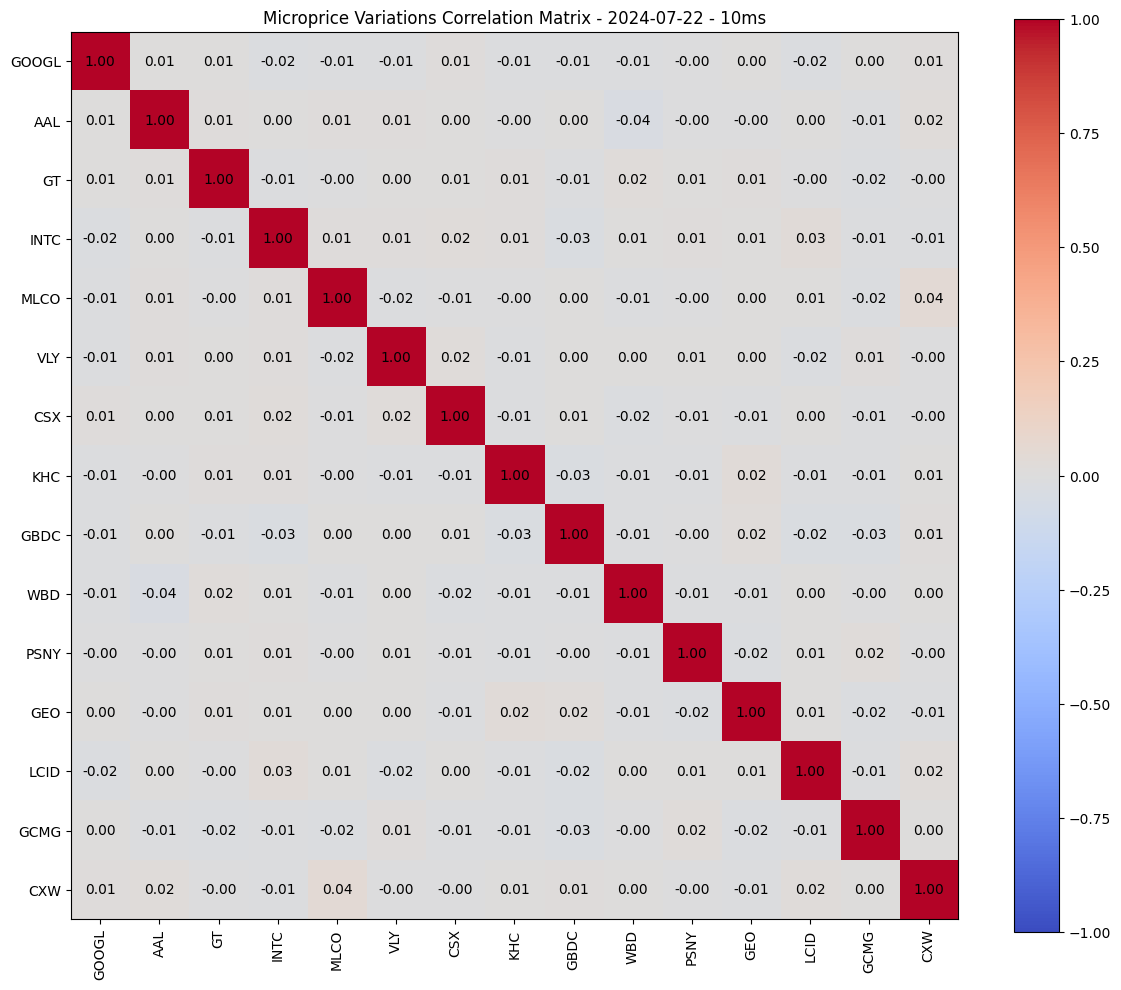


Processing time scale: 1s
Processing stock: GOOGL
First 5 variations for GOOGL:
[-0.00452613  0.02760753 -0.01714206  0.00481075  0.01034413]
Number of data points for GOOGL: 12041
Processing stock: AAL
First 5 variations for AAL:
[-0.00204771  0.00218822  0.         -0.00044864  0.00058317]
Number of data points for AAL: 17008
Processing stock: GT
First 5 variations for GT:
[ 0.          0.00089959  0.01187229 -0.00500139  0.005     ]
Number of data points for GT: 12729
Processing stock: INTC
First 5 variations for INTC:
[ 0.01834207 -0.00705977  0.00877364  0.01593318  0.00099753]
Number of data points for INTC: 22249
Processing stock: MLCO
First 5 variations for MLCO:
[ 0.          0.         -0.00028116  0.00093516  0.        ]
Number of data points for MLCO: 8959
Processing stock: VLY
First 5 variations for VLY:
[ 3.16666456e-04 -7.27647221e-04  1.58737574e-02 -7.08349344e-05
  7.21537322e-03]
Number of data points for VLY: 13152
Processing stock: CSX
First 5 variations for CSX:


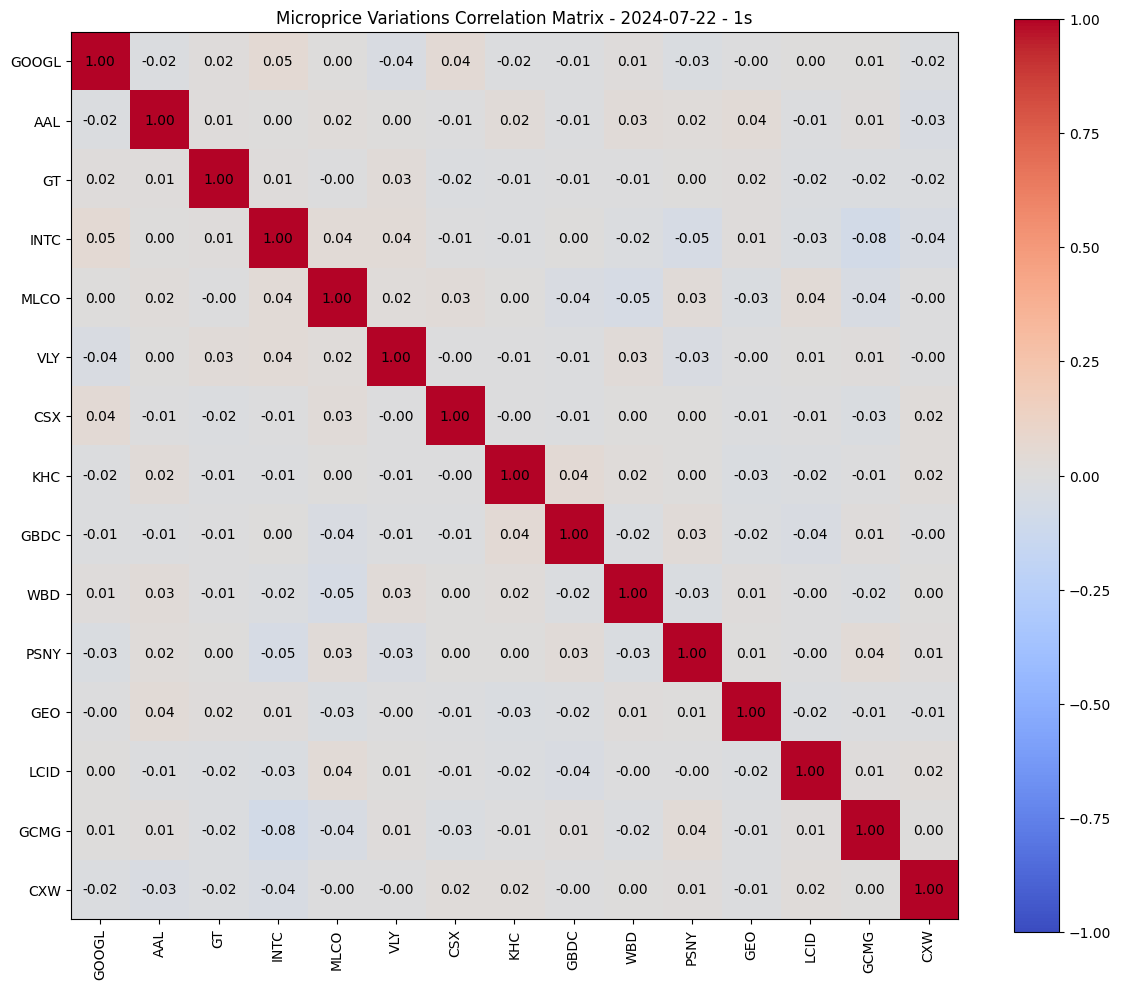


Processing time scale: 10s
Processing stock: GOOGL
First 5 variations for GOOGL:
[ 0.022316   -0.02102812  0.00256742  0.01333042 -0.10636974]
Number of data points for GOOGL: 1780
Processing stock: AAL
First 5 variations for AAL:
[ 0.00153454  0.00931179  0.00190504 -0.00230962  0.0075477 ]
Number of data points for AAL: 2309
Processing stock: GT
First 5 variations for GT:
[ 0.01940025  0.00116675 -0.00025331  0.00076897  0.00339721]
Number of data points for GT: 2297
Processing stock: INTC
First 5 variations for INTC:
[ 0.00341257 -0.02032348  0.03407867 -0.09647461 -0.02846081]
Number of data points for INTC: 2309
Processing stock: MLCO
First 5 variations for MLCO:
[ 0.00093516  0.         -0.00239316 -0.02230769  0.        ]
Number of data points for MLCO: 2221
Processing stock: VLY
First 5 variations for VLY:
[ 0.02203629  0.00171137 -0.00054318 -0.01016233  0.00055231]
Number of data points for VLY: 2298
Processing stock: CSX
First 5 variations for CSX:
[ 0.05167291  0.01744474 

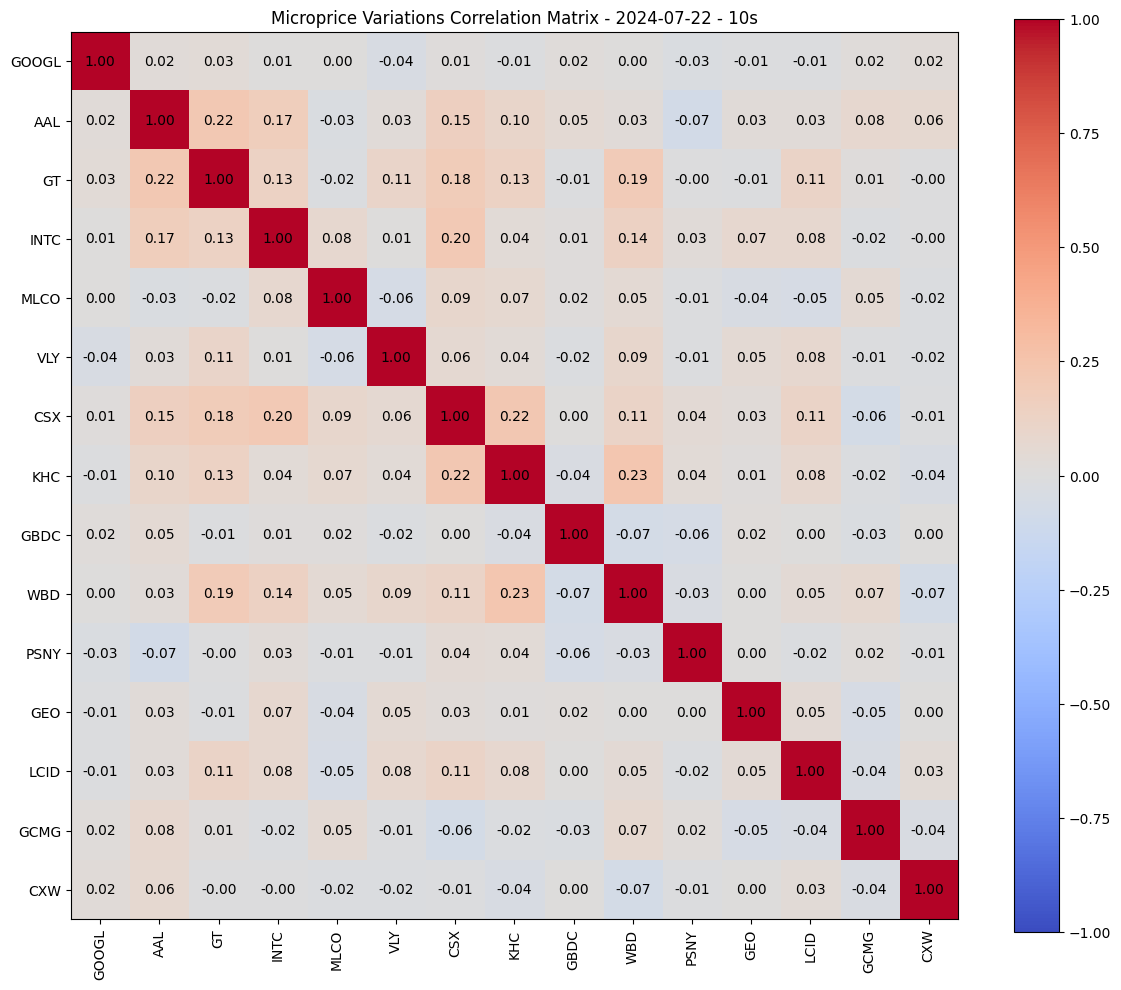


Correlation analysis complete.


In [ ]:
# --- Main Processing Loop ---

print("\nCalculating correlation matrices for microprice variations...")

# Define time scales for resampling
time_scales = ["10s", "1s", "10ms"]
time_scales.reverse()

for time_scale in time_scales:
    print(f"\nProcessing time scale: {time_scale}")
    
    # Sample each stock at regular intervals and calculate variations
    stock_variations = {}
    for stock in date_stocks[most_common_dates[0]]:
        print(f"Processing stock: {stock}")
        df = all_dfs[stock]
        
        # Resample data at regular intervals using group_by_dynamic
        sampled_prices = df.group_by_dynamic(
            "ts_event",
            every=time_scale
        ).agg([
            pl.col("microprice").last().alias("microprice")
        ])
        
        # Calculate microprice variations (differences)
        variations = np.diff(sampled_prices["microprice"].to_numpy())
        stock_variations[stock] = variations
        
        # Print first 5 values of the time series
        print(f"First 5 variations for {stock}:")
        print(variations[:5])
        print(f"Number of data points for {stock}: {len(variations)}")
    
    # Ensure all stocks have same number of variations
    min_length = min(len(variations) for variations in stock_variations.values())
    for stock in stock_variations:
        stock_variations[stock] = stock_variations[stock][:min_length]
    
    print(f"\nAll stocks trimmed to {min_length} data points")
    
    # Create correlation matrix
    stocks = list(stock_variations.keys())
    corr_matrix = np.zeros((len(stocks), len(stocks)))
    
    for i in range(len(stocks)):
        for j in range(len(stocks)):
            corr = np.corrcoef(stock_variations[stocks[i]], stock_variations[stocks[j]])[0,1]
            corr_matrix[i,j] = corr
    
    # Plot correlation matrix
    plt.figure(figsize=(12, 10))
    plt.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
    plt.colorbar()
    plt.xticks(range(len(stocks)), stocks, rotation=90)
    plt.yticks(range(len(stocks)), stocks)
    plt.title(f"Microprice Variations Correlation Matrix - {most_common_dates[0]} - {time_scale}")
    
    # Add correlation values in the center of each cell
    for i in range(len(stocks)):
        for j in range(len(stocks)):
            plt.text(j, i, f'{corr_matrix[i,j]:.2f}', 
                    ha='center', va='center', color='black')
    
    plt.tight_layout()
    plt.savefig(f"/home/janis/HFTP2/HFT/results/correlation/variations_matrix_{most_common_dates[0]}_{time_scale}.png")
    plt.show()

print("\nCorrelation analysis complete.")